In [1]:
import pandas as pd
import numpy as np
import time
import re
import operator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../dataset/TBN_CIF.csv", header=0)
# sd = pd.read_csv("../dataset/TBN_Y_ZERO.csv", header=0)
df.head()

CUST_NO  AGE  CHILDREN_CNT  CUST_START_DT  EDU_CODE GENDER_CODE  \
0  UFUIMEGMK2KTIWI4    1           NaN            2.0       NaN         NaN   
1  3HJN2X_LGBHBKILI    3           0.0         9393.0       NaN         NaN   
2  MNEZK2O3OE-JHYBW    4           0.0         2912.0       3.0           M   
3  W7ADZSWYXEMHB7JQ    4           0.0         8332.0       5.0           M   
4  ODB6BA6ORHL2UYZE    4           0.0          744.0       3.0           M   

   INCOME_RANGE_CODE  WORK_MTHS  
0                NaN        NaN  
1                1.0        NaN  
2                2.0        2.0  
3                2.0        1.0  
4                2.0        1.0

In [3]:
#1. 分析數據
df.describe()
#總共 : 187679
#AGE : 0 缺失
#CHILDREN_CNT : 432 缺失
#CUST_START_DT : 0 缺失
#EDU_CODE : 28,988 缺失
#INCOME_RANGE_CODE : 382 缺失
#WORK_MTHS : 36,190 缺失

AGE   CHILDREN_CNT  CUST_START_DT       EDU_CODE  \
count  187679.000000  187247.000000  187679.000000  158691.000000   
mean        2.511053       0.023509    6260.023998       3.632077   
std         1.105938       0.224682    2385.903856       1.211771   
min         1.000000       0.000000       0.000000       1.000000   
25%         2.000000       0.000000    4296.000000       3.000000   
50%         3.000000       0.000000    6747.000000       3.000000   
75%         3.000000       0.000000    8367.000000       5.000000   
max         4.000000      10.000000    9567.000000       6.000000   

       INCOME_RANGE_CODE      WORK_MTHS  
count      187297.000000  151489.000000  
mean            1.208236       1.058757  
std             0.536134       0.238984  
min             1.000000       1.000000  
25%             1.000000       1.000000  
50%             1.000000       1.000000  
75%             1.000000       1.000000  
max             4.000000       5.000000

In [4]:
#2. 產生測試資料 2018/01
tfCIF = df.drop(["CHILDREN_CNT","INCOME_RANGE_CODE","WORK_MTHS","GENDER_CODE"], axis=1) #去除不必要資料
tfCIF = tfCIF.fillna(0) #有缺失值的都補0
tfCIF.head()

CUST_NO  AGE  CUST_START_DT  EDU_CODE
0  UFUIMEGMK2KTIWI4    1            2.0       0.0
1  3HJN2X_LGBHBKILI    3         9393.0       0.0
2  MNEZK2O3OE-JHYBW    4         2912.0       3.0
3  W7ADZSWYXEMHB7JQ    4         8332.0       5.0
4  ODB6BA6ORHL2UYZE    4          744.0       3.0

In [5]:
#加欄位
tf = pd.concat(
    [
        tfCIF,
        pd.DataFrame(
            [[0,0,0,0,0,0,0,0]], 
            index=tfCIF.index, 
            columns=['CC_READ_1', 'CC_READ_2', 'CC_READ_3', 'CC_READ_4', 'CC_PREDICT_2', 'CC_PREDICT_3', 'CC_PREDICT_4', 'CC_PREDICT_5']
        )
    ], axis=1
)
tf.head()

CUST_NO  AGE  CUST_START_DT  EDU_CODE  CC_READ_1  CC_READ_2  \
0  UFUIMEGMK2KTIWI4    1            2.0       0.0          0          0   
1  3HJN2X_LGBHBKILI    3         9393.0       0.0          0          0   
2  MNEZK2O3OE-JHYBW    4         2912.0       3.0          0          0   
3  W7ADZSWYXEMHB7JQ    4         8332.0       5.0          0          0   
4  ODB6BA6ORHL2UYZE    4          744.0       3.0          0          0   

   CC_READ_3  CC_READ_4  CC_PREDICT_2  CC_PREDICT_3  CC_PREDICT_4  \
0          0          0             0             0             0   
1          0          0             0             0             0   
2          0          0             0             0             0   
3          0          0             0             0             0   
4          0          0             0             0             0   

   CC_PREDICT_5  
0             0  
1             0  
2             0  
3             0  
4             0

In [6]:
#9448~9567  (2017/12/28~2018/4/27)
#----------------------------------
#9448~9477  (2017/12/28~2018/1/27) LN_READ_1
#9478~9507  (2018/1/28~2018/2/27)  LN_READ_2, LN_PREDICT_2
#9408~9537  (2018/2/28~2018/3/27)  LN_READ_3, LN_PREDICT_3
#9438~9567  (2018/3/28~2018/4/27)  LN_READ_4, LN_PREDICT_4
#--------------------------------
#9568~9597  (2018/4/28~2018/5/27)  LN_PREDICT_5
#RDAD已存入csv READ_CC_214.csv
# start = time.time()
# READ = pd.read_csv("../dataset/TBN_CUST_BEHAVIOR_TRAN.csv", header=0) #瀏覽網頁資料 客戶行為訓練
# READ.loc[(READ.VISITDATE>=9448) & (READ.VISITDATE<=9477),'VISITDATE'] = 1
# READ.loc[(READ.VISITDATE>=9478) & (READ.VISITDATE<=9507),'VISITDATE'] = 2
# READ.loc[(READ.VISITDATE>=9508) & (READ.VISITDATE<=9537),'VISITDATE'] = 4
# READ.loc[(READ.VISITDATE>=9538) & (READ.VISITDATE<=9567),'VISITDATE'] = 8
# end = time.time()
# print("花費時間:",end-start)

In [7]:
#RDAD已存入csv READ_CC_214.csv
# start = time.time()
# def cal_CC_READ(row):
#     if re.match(r".*credit-card.*", row["PAGE//"]):
#         row["PAGE//"] = 1
#     else:
#         row["PAGE//"] = 0
#     return row
# READ = READ.apply(cal_CC_READ, axis=1)
# end = time.time()
# print("花費時間:",end-start)
# READ.to_csv('READ_CC_214.csv', index=False)
READ = pd.read_csv("../src/READ_CC_214.csv", header=0) #瀏覽網頁資料 客戶行為訓練
READ.head()

CUST_NO  VISITDATE  PAGE//
0  AZTHNWQ_LXMGIMYG          1       0
1  AZTHNWQ_LXMGIMYG          4       0
2  3PY428CHUQBULFIG          1       0
3  JVPD1QUJWVLMZU8S          1       0
4  JVPD1QUJWVLMZU8S          2       0

In [8]:
#查看不同PAGE//個數 --> loan 16萬(不包含房貸)
temp1=READ['PAGE//'].value_counts(ascending=True)
temp1
#取有值的
READ1 = READ[READ["PAGE//"] > 0]
READ1.head()

CUST_NO  VISITDATE  PAGE//
40  UT8OOUMHJ0JVEDMS          1       1
41  UT8OOUMHJ0JVEDMS          2       1
42  UT8OOUMHJ0JVEDMS          2       1
50  DX-ULHMCEG2BBHV4          1       1
51  DX-ULHMCEG2BBHV4          1       1

In [9]:
#當成hash跑比較快
start = time.time()
d_read = dict()
for index, row in READ1.iterrows():
    if (row["CUST_NO"] in d_read.keys()):
        if row["VISITDATE"] == 1:
            d_read[row["CUST_NO"]] |= 1
        elif row["VISITDATE"] == 2:
            d_read[row["CUST_NO"]] |= 2
        elif row["VISITDATE"] == 4:
            d_read[row["CUST_NO"]] |= 4
        elif row["VISITDATE"] == 8:
            d_read[row["CUST_NO"]] |= 8            
    else:
        d_read[row["CUST_NO"]] = row["VISITDATE"]
# for i in d_read: #有些人不同季信貸
#     if d_read[i] > 9:
#         print(i)
end = time.time()
print("花費時間:",end-start)

花費時間: 47.07902002334595


In [10]:
# READ1.loc[READ1.CUST_NO == "RAAZN8JK3_IB1VQS"]
# d_read["RAAZN8JK3_IB1VQS"]

In [11]:
PREDICT = pd.read_csv("../dataset/TBN_CC_APPLY.csv", header=0) #信用卡申請資料 預測資料
PREDICT.loc[(PREDICT.TXN_DT<9478),'TXN_DT'] = 0
PREDICT = PREDICT[PREDICT.TXN_DT > 0]
PREDICT.loc[(PREDICT.TXN_DT>=9478) & (PREDICT.TXN_DT<=9507),'TXN_DT'] = 1
PREDICT.loc[(PREDICT.TXN_DT>=9508) & (PREDICT.TXN_DT<=9537),'TXN_DT'] = 2
PREDICT.loc[(PREDICT.TXN_DT>=9538) & (PREDICT.TXN_DT<=9567),'TXN_DT'] = 4
PREDICT.head()

#當成hash跑比較快
d_predict = dict()
for index, row in PREDICT.iterrows():
    if (row["CUST_NO"] in d_predict.keys()):
        if row["TXN_DT"] == 1:
            d_predict[row["CUST_NO"]] |= 1
        elif row["TXN_DT"] == 2:
            d_predict[row["CUST_NO"]] |= 2
        elif row["TXN_DT"] == 4:
            d_predict[row["CUST_NO"]] |= 4
    else:
        d_predict[row["CUST_NO"]] = row["TXN_DT"]

# for i in d_predict: #有些人不同季信貸
#     if d_predict[i] > 4:
#         print(i)
# PREDICT.loc[PREDICT.CUST_NO == "EBQUS_PNHMV8KY6Q"]

In [12]:
###############################test
# temp1=READ['VISITDATE'].value_counts(ascending=True)
# temp1
# if not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 1)].empty):
#     print(1)
# elif not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 2)].empty):
#     print(2)
# elif not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 3)].empty):
#     print(3)
# elif not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 4)].empty):    
#     print(4)
# else:
#     print(5)
# READ1.loc[(READ1.CUST_NO == "YV7EFLVIAQER2KRU") & (READ1.VISITDATE == 2)].empty
############################test

# READ1.loc[(READ1.CUST_NO == "MNEZK2O3OE-JHYBW")]
# if (d_read["MNEZK2O3OE-JHYBW"] & 1):
#     print(1)
# else:
#     print(2)

In [62]:
start = time.time()
def cal_CC(row):
    if (row["CUST_NO"] in d_read.keys()):
        if (d_read[row.CUST_NO] & 1):
            row["CC_READ_1"] += 1
        if (d_read[row.CUST_NO] & 2):
            row["CC_READ_2"] += 1
        if (d_read[row.CUST_NO] & 4):
            row["CC_READ_3"] += 1
        if (d_read[row.CUST_NO] & 8):
            row["CC_PREDICT_4"] = 1
            row["CC_READ_4"] += 1

    if (row["CUST_NO"] in d_predict.keys()):
        if (d_predict[row.CUST_NO] & 1):
            row["CC_PREDICT_2"] += 1
        if (d_predict[row.CUST_NO] & 2):
            row["CC_PREDICT_3"] += 1
        if (d_predict[row.CUST_NO] & 4):
            row["CC_PREDICT_4"] = 1

    return row
tf = tf.apply(cal_CC, axis=1)
td = tf.drop(["CUST_NO"], axis=1)
end = time.time()
print("花費時間:",end-start)

花費時間: 32.98281216621399


In [14]:
td.describe() # training data 準備好

AGE  CUST_START_DT       EDU_CODE     CC_READ_1  \
count  187679.000000  187679.000000  187679.000000  187679.00000   
mean        2.511053    6260.023998       3.071084       0.04976   
std         1.105938    2385.903856       1.721759       0.21745   
min         1.000000       0.000000       0.000000       0.00000   
25%         2.000000    4296.000000       2.000000       0.00000   
50%         3.000000    6747.000000       3.000000       0.00000   
75%         3.000000    8367.000000       4.000000       0.00000   
max         4.000000    9567.000000       6.000000       1.00000   

           CC_READ_2      CC_READ_3      CC_READ_4   CC_PREDICT_2  \
count  187679.000000  187679.000000  187679.000000  187679.000000   
mean        0.060145       0.071569       0.066459       0.020109   
std         0.237756       0.257774       0.249084       0.140373   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

        CC_PREDICT_3   CC_PREDICT_4  CC_PREDICT_5  
count  187679.000000  187679.000000      187679.0  
mean        0.032662       0.047896           0.0  
std         0.177751       0.213546           0.0  
min         0.000000       0.000000           0.0  
25%         0.000000       0.000000           0.0  
50%         0.000000       0.000000           0.0  
75%         0.000000       0.000000           0.0  
max         1.000000       1.000000           0.0

In [15]:
#查看不同AGE個數
# temp1=td['AGE'].value_counts(ascending=True)
# temp1

In [65]:
#2018/1
#分訓練跟測試資料
td1 = td.drop(['CC_READ_1','CC_READ_2','CC_READ_3','CC_READ_4','CC_PREDICT_2','CC_PREDICT_3','CC_PREDICT_5'], axis=1)
X = td1.drop('CC_PREDICT_4', axis=1)
X = preprocessing.scale(X) #標準化
y = td1.CC_PREDICT_4
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
# X

In [66]:
#演算法-隨機森林
model=RandomForestClassifier()
start=time.time()
model.fit(X_train,y_train)
train_predict=model.predict(X_train)
train_f1=metrics.f1_score(train_predict,y_train)
train_accuracy=metrics.accuracy_score(train_predict,y_train)
train_recall=metrics.recall_score(train_predict,y_train)
print('train f1_mean = %.4f' % train_f1, end='\n')
print('train 精確率   = %.4f' % train_accuracy, end='\n')
print('train 召回率   = %.4f' % train_recall)
test_predict=model.predict(X_test)
test_f1=metrics.f1_score(test_predict,y_test)
test_accuracy=metrics.accuracy_score(test_predict,y_test)
test_recall=metrics.recall_score(test_predict,y_test)
print('='*50)
print('test f1_mean = %.4f' % test_f1, end='\n')
print('test 精確率   = %.4f' % test_accuracy, end='\n')
print('test 召回率   = %.4f' % test_recall)
end=time.time()
print('='*50)
print('花費時間 = %.4f' % (end-start))

train f1_mean = 0.4932
train 精確率   = 0.9185
train 召回率   = 0.7750
test f1_mean = 0.1387
test 精確率   = 0.8557
test 召回率   = 0.2020
花費時間 = 3.4844


In [18]:
#2018/2
#分訓練跟測試資料
td2 = td.drop(['CC_READ_3','CC_READ_4','CC_PREDICT_4','CC_PREDICT_5'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(td2.drop('CC_PREDICT_3', axis=1), td2.CC_PREDICT_3, train_size=0.9, test_size=0.1)

In [19]:
#演算法-隨機森林2
start=time.time()
model.fit(X_train,y_train)
train_predict=model.predict(X_train)
train_f1=metrics.f1_score(train_predict,y_train)
train_accuracy=metrics.accuracy_score(train_predict,y_train)
train_recall=metrics.recall_score(train_predict,y_train)
print('train f1_mean = %.4f' % train_f1, end='\n')
print('train 精確率   = %.4f' % train_accuracy, end='\n')
print('train 召回率   = %.4f' % train_recall)
test_predict=model.predict(X_test)
test_f1=metrics.f1_score(test_predict,y_test)
test_accuracy=metrics.accuracy_score(test_predict,y_test)
test_recall=metrics.recall_score(test_predict,y_test)
print('='*50)
print('test f1_mean = %.4f' % test_f1, end='\n')
print('test 精確率   = %.4f' % test_accuracy, end='\n')
print('test 召回率   = %.4f' % test_recall)
end=time.time()
print('='*50)
print('花費時間 = %.4f' % (end-start))

train f1_mean = 0.5799
train 精確率   = 0.9793
train 召回率   = 0.8593
test f1_mean = 0.2237
test 精確率   = 0.9634
test 召回率   = 0.3536
花費時間 = 3.6768


In [20]:
#2018/3
#分訓練跟測試資料
td3 = td.drop(['CC_READ_4','CC_PREDICT_5'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(td3.drop('CC_PREDICT_4', axis=1), td3.CC_PREDICT_4, train_size=0.9, test_size=0.1)

In [21]:
#演算法-隨機森林3
start=time.time()
model.fit(X_train,y_train)
train_predict=model.predict(X_train)
train_f1=metrics.f1_score(train_predict,y_train)
train_accuracy=metrics.accuracy_score(train_predict,y_train)
train_recall=metrics.recall_score(train_predict,y_train)
print('train f1_mean = %.4f' % train_f1, end='\n')
print('train 精確率   = %.4f' % train_accuracy, end='\n')
print('train 召回率   = %.4f' % train_recall)
test_predict=model.predict(X_test)
test_f1=metrics.f1_score(test_predict,y_test)
test_accuracy=metrics.accuracy_score(test_predict,y_test)
test_recall=metrics.recall_score(test_predict,y_test)
print('='*50)
print('test f1_mean = %.4f' % test_f1, end='\n')
print('test 精確率   = %.4f' % test_accuracy, end='\n')
print('test 召回率   = %.4f' % test_recall)
end=time.time()
print('='*50)
print('花費時間 = %.4f' % (end-start))

train f1_mean = 0.5895
train 精確率   = 0.9697
train 召回率   = 0.8570
test f1_mean = 0.2023
test 精確率   = 0.9450
test 召回率   = 0.2723
花費時間 = 3.4021


In [72]:
#2018/4 實際資料
# td4 = tf.drop(['CC_READ_1','CC_PREDICT_2','CC_PREDICT_5'], axis=1)
# td4.to_csv('td4.csv', index= False)
# res = model.predict(td4)
# res
tfCIF.head()
tfCIF.to_csv('td4.csv', index= False)


In [71]:
submit = pd.read_csv('../src/TBN_Y_ZERO_214_v2.csv')
#submit = submit.drop(["FX_IND","FX_IND","LN_IND","WM_IND"], axis=1)
#submit = submit.sort_values(["CUST_NO"])
submit.head(n=5)

CUST_NO  CC_IND  FX_IND  LN_IND  WM_IND
0  _PT5HFBEZJKOZ934       0       0       0       0
1  6STXUMWZRDCGSDDU       0       0       0       0
2  JDVF4U8JUANEID68       0       1       0       0
3  8I6SQDGP9OQYUN1M       0       0       0       0
4  R-TRDUV3GHTID31I       0       0       0       0

In [76]:
a = pd.read_csv('../dataset_4/td4_4.csv')
a = a.sort_values(["CUST_NO"])
# # count = 0
# insert = pd.DataFrame([[13,0,0,0,0,0,0,0,0]],columns=["CUST_NO","AGE","CUST_START_DT","EDU_CODE","LN_READ_2","LN_READ_3","LN_READ_4","LN_PREDICT_3","LN_PREDICT_4"])
# above = a.iloc[:12]
# below = a.iloc[13:]
# # b = a.iloc[12].append(insert,ignore_index=True).append(14,ignore_index=True)
# # a.loc[:12]
# b = above.append(insert,ignore_index=True).append(below,ignore_index=True)
# # b = a.append([insert], ignore_index=True)
# b
start = time.time()
count = 0
for i in range(len(submit)):
    if a.loc[a.CUST_NO == count].empty:
        insert = pd.DataFrame([[count,0,0,0]],columns=["CUST_NO","AGE","CUST_START_DT","EDU_CODE"])
        above = a.iloc[:count]
        below = a.iloc[count:]
        a = above.append(insert,ignore_index=True).append(below,ignore_index=True)
    count+=1

end = time.time()
print("花費時間:",end-start)
a


花費時間: 21.044750690460205


CUST_NO  AGE  CUST_START_DT  EDU_CODE
0            0    4         2912.0       4.0
1            1    2         7686.0       3.0
2            2    4         2484.0       3.0
3            3    1         7754.0       6.0
4            4    4         4062.0       2.0
5            5    3         4996.0       2.0
6            6    4         1842.0       3.0
7            7    4         1836.0       4.0
8            8    4         8070.0       6.0
9            9    2         7217.0       3.0
10          10    2         4555.0       6.0
11          11    3         2220.0       4.0
12          12    3         7370.0       2.0
13          13    2         7231.0       0.0
14          14    4         4065.0       6.0
15          15    3         4678.0       4.0
16          16    4         1840.0       4.0
17          17    4         3180.0       3.0
18          18    2         8461.0       2.0
19          19    4         3465.0       6.0
20          20    1         7803.0       3.0
21          21    3         2893.0       4.0
22          22    4         1004.0       5.0
23          23    2         9053.0       0.0
24          24    4         4587.0       6.0
25          25    1         9408.0       6.0
26          26    2         7854.0       5.0
27          27    1         6760.0       3.0
28          28    4         6663.0       5.0
29          29    3         3009.0       2.0
...        ...  ...            ...       ...
29970    29970    3         1823.0       5.0
29971    29971    1         7882.0       0.0
29972    29972    2         3155.0       4.0
29973    29973    2         4235.0       4.0
29974    29974    1         9546.0       3.0
29975    29975    2         3829.0       3.0
29976    29976    3         4555.0       6.0
29977    29977    3         7376.0       3.0
29978    29978    2         8609.0       3.0
29979    29979    1         9059.0       0.0
29980    29980    2         7894.0       4.0
29981    29981    2         8000.0       2.0
29982    29982    1         7757.0       3.0
29983    29983    4         4990.0       3.0
29984    29984    4         2746.0       5.0
29985    29985    2         7552.0       3.0
29986    29986    4         4849.0       5.0
29987    29987    2         8560.0       5.0
29988    29988    3         6271.0       3.0
29989    29989    4         4138.0       4.0
29990    29990    3         3659.0       3.0
29991    29991    2         7757.0       2.0
29992    29992    1         8524.0       0.0
29993    29993    3         6763.0       3.0
29994    29994    3         3849.0       4.0
29995    29995    4         3008.0       4.0
29996    29996    1         8189.0       3.0
29997    29997    2         9070.0       2.0
29998    29998    2         7835.0       2.0
29999    29999    3         5701.0       3.0

[30000 rows x 4 columns]

In [77]:
final_test = a.drop(["CUST_NO"], axis=1)
#submit = submit.drop(["FX_IND","FX_IND","LN_IND","WM_IND"], axis=1)

res = model.predict(final_test)
res

array([1, 1, 1, ..., 1, 1, 1])

In [78]:
count=0
for i in res:
    if i > 0:
        count+=1
print("1有",count,"個")

1有 29848 個


In [79]:
submit["CC_IND"] = res
submit.head()
submit.to_csv('submit.csv', index= False)

[ 0.00276666  0.95563943  0.04159391]
0.955639429332


ValueError: shape mismatch: objects cannot be broadcast to a single shape

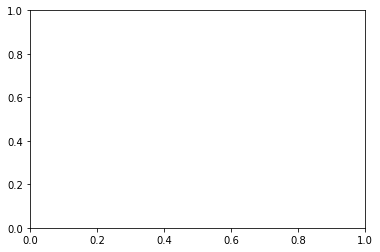

In [80]:
feature_importance = model.feature_importances_ #度量特征权重的接口
print(feature_importance) 
#特征的相关属性值
print(feature_importance.max())
#最大特征的属性值
feature_importance=100.0*(feature_importance/feature_importance.max())
index=np.argsort(feature_importance)[-:] #倒序排列，倒数10个排名
plt.barh(np.arange(3), feature_importance[index], color='dodgerblue', alpha=0.4)
print(np.array(final_test.columns)[index])
plt.yticks(np.arange(10+0.25), np.array(final_test.columns)[index])
plt.xlabel('Relative importance')
plt.title('Top 10 Importance Variable')
plt.show()